In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from numba import jit
import seaborn as sns

visual_drift_coef = 1
memory_drift_coef = 1/3

path_figs = "./Figs/"

I can add visual delay later to account for bigger RT at the beginning

Important: Check for memory drift adding after a press or after the visual delay for the next press

In [2]:
%load_ext line_profiler

In [3]:
def calc_visual_drifts(seq, seq_length):
    seq_fingers = np.array([int(_) for _ in seq]) - 1
    result = np.zeros((5, seq_length))

    result[seq_fingers, np.arange(seq_length)] = visual_drift_coef


    return result



In [4]:
def calc_memory_drifts(specific_seq, seq_length):
    seq_fingers = np.array([int(_) for _ in specific_seq]) - 1
    result = np.zeros((5, seq_length))

    result[seq_fingers, np.arange(seq_length)] = memory_drift_coef


    return result

In [5]:
seq = '1'
specific_seq = '1'
rand_seq = '5'


seq_length = len(seq)

window_sizes = [1,2,3,4,11]

visual_drifts = calc_visual_drifts(seq, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)

# drifts = np.array([1,1,1,1,2]).reshape(5, 1)
# drifts = np.repeat(drifts, seq_length , axis = 1)

visual_delay = 100
motor_delay = 50

diffusion = 2
threshold = 300


In [6]:
visual_drifts

array([[1.],
       [0.],
       [0.],
       [0.],
       [0.]])

In [7]:
memory_drifts

array([[0.33333333],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ]])

In [8]:
@jit(nopython=True)
def get_planning_coefs(strategy, capacity, param):
    if strategy == 0:
        return exp_normalized_planning_jit(capacity, param)
    elif strategy == 1:
        return inv_normalized_planning_jit(capacity)
    else:
        raise ValueError("Unknown strategy")

@jit(nopython=True)
def exp_normalized_planning_jit(capacity, param):
    x = np.arange(capacity)
    theta = np.exp(-x * np.log(param))
    theta /= np.sum(theta)
    return theta

@jit(nopython=True)
def inv_normalized_planning_jit(capacity):
    x = np.arange(capacity)
    theta = 1 / (x + 1)
    theta /= np.sum(theta)
    return theta

In [9]:
def exp_normalized_planning(capacity=3, param = 3):
    """
    Exponential decay function for planning

    args: 
        capacity (int): capacity of planning
        param (list/np.array): rate
    """
    x = np.arange(capacity)
    theta = np.exp(-x * np.log(param))
    theta /= sum(theta)

    return theta


def inv_normalized_planning(capacity=3):
    x = np.arange(capacity)
    theta = 1/(x+1)
    theta /= sum(theta)

    return theta

In [10]:
def check_evidence_to_seq(evidence, seq):
    for press in range(len(seq)):
        if ~(np.argmax(evidence[:, press]) + 1 == int(seq[press])):
            return False
    return True

In [11]:
def calculate_IPI_from_press_time(press_times):

   return [press_times[0]] + [press_times[i] - press_times[i-1] for i in range(1, len(press_times))]

In [12]:
@jit(nopython=True)
def simulate_ddm_damping_lateral(seq, specific_seq, visual_drifts, memory_drifts, 
                                 diffusion, threshold, dt, max_time, seq_length, 
                                 window_size, planning_capacity, planning_param, planning_strategy, 
                                 visual_delay, motor_delay, alpha, beta):
    evidence = np.zeros((5, seq_length))
    time = 0
    visual_delay_queue = np.zeros(min(window_size, seq_length, planning_capacity))
    motor_delay_queue = np.zeros(0)
    current_press_planned = 0
    current_press_execed = 0
    effective_planning_capacity = 0
    visible_window_size = 0

    planning_coefs = get_planning_coefs(planning_strategy, effective_planning_capacity, planning_param)


    sqrt_dt = np.sqrt(dt)
    drifts_visual_dt = visual_drifts * dt
    drifts_memory_dt = memory_drifts * dt
    diffusion_term = diffusion * sqrt_dt

    total_steps = int(max_time / dt)
    random_terms = np.random.randn(5, seq_length, total_steps)
    random_terms_memory = np.random.rand(5, total_steps)

    t_index = 0

    press_times = np.full(seq_length, np.nan)

    A = np.eye(5) * alpha - np.full((5,5), beta) + np.eye(5) * beta


    while time < max_time - dt:
        time += dt
        visual_delay_queue += dt
        if len(motor_delay_queue) > 0:
            motor_delay_queue[0] += dt
        t_index += 1

        evidence[:, current_press_planned: ] = A @ evidence[:, current_press_planned: ]
        evidence[:, current_press_planned:] += diffusion_term * random_terms[:, current_press_planned:, t_index]


        for press in range(current_press_planned, min(current_press_planned + visible_window_size, seq_length, current_press_planned + planning_capacity)):
            
            # evidence[:, press] = A @ evidence[:, press]

            # evidence[:, press] = np.matmul(A, evidence[:, press])
            # evidence[:, press] = np.dot(A, evidence[:, press])
            evidence[:, press] += planning_coefs[press - current_press_planned] * drifts_visual_dt[:, press]
            # evidence[:, press] += planning_coefs[press - current_press_planned] * drifts_visual_dt[:, press] + diffusion_term * random_terms[:, t_index]
            if press == current_press_planned:
                # if seq[current_press_planned] == specific_seq[current_press_planned]:
                    # evidence[:, current_press_planned] += drifts_memory_dt[:, current_press_planned] + diffusion_term / 2 * random_terms_memory[:, t_index]
                    # evidence[:, current_press_planned] += drifts_memory_dt[:, current_press_planned]
                evidence[:, current_press_planned] += drifts_memory_dt[:, current_press_planned]

        evidence[:, current_press_planned: ] = np.maximum(0, evidence[:, current_press_planned: ])


        if (evidence[:, current_press_planned:min(current_press_planned + visible_window_size, seq_length, current_press_planned + planning_capacity)] >= threshold).any():
            visible_window_size -= 1
            # press_times[current_press_planned] = time
            current_press_planned += 1
            motor_delay_queue = np.append(motor_delay_queue, 0)
            # visual_delay_queue = np.append(visual_delay_queue, 0)
            effective_planning_capacity = min(visible_window_size, seq_length - current_press_planned, planning_capacity)
            planning_coefs = get_planning_coefs(planning_strategy, effective_planning_capacity, planning_param)

        if len(motor_delay_queue) > 0 and motor_delay_queue[0] >= motor_delay:
            motor_delay_queue = motor_delay_queue[1:]
            visual_delay_queue = np.append(visual_delay_queue, 0)
            press_times[current_press_execed] = time
            current_press_execed += 1
            if current_press_execed == seq_length:
                break

        visual_delay_passed_mask = (visual_delay_queue >= visual_delay)
        pass_count = sum(visual_delay_passed_mask)
        if pass_count > 0:
            visible_window_size += pass_count
            visual_delay_queue = visual_delay_queue[~visual_delay_passed_mask]
            effective_planning_capacity = min(visible_window_size, seq_length - current_press_planned, planning_capacity)
            planning_coefs = get_planning_coefs(planning_strategy, effective_planning_capacity, planning_param)


    return press_times, evidence

In [13]:
class DriftDiffusionModel_Optimzied_damping_lateral:
    def __init__(self, seq, specific_seq, visual_drifts, memory_drifts, diffusion, threshold, dt = 1, max_time = 10000,  #todo: when changing dt, the round(time, 2) should be changed according to the precision of dt
                 seq_length = 11, window_size = 2, planning_capacity = 3, planning_param = 3,  
                 planning_strategy = 0, visual_delay = visual_delay, motor_delay = motor_delay, alpha = 0.99, beta = 0.005): #todo: consider having different diffusions for different fingers (e.g. should we have different one when interference happens?)
        """
        Initialize the Drift-Diffusion Model.

        Parameters:
        drifts (list of float): List of drift rates for each process.
        diffusion (float): Diffusion coefficient (assumed to be the same for all processes).
        threshold (float): Decision threshold.
        dt (float): Time step for the discrete-time simulation.
        max_time (float): Maximum simulation time to prevent infinite loops.
        """
        self.seq_length = seq_length
        self.presses = [None for _ in range(seq_length)]
        self.window_size = window_size
        assert visual_drifts.shape == (5,seq_length), "There must be exactly 5 drift rates."
        self.visual_drifts = visual_drifts 
        self.memory_drifts = memory_drifts
        self.diffusion = diffusion
        self.threshold = threshold
        self.dt = dt
        self.max_time = max_time
        self.planning_strategy = planning_strategy
        self.planning_capacity = planning_capacity
        self.planning_param = planning_param
        self.press_times = [None for _ in range(seq_length)]
        self.visual_delay = visual_delay
        self.motor_delay = motor_delay
        self.seq = seq
        self.specific_seq = specific_seq
        self.alpha = alpha
        self.beta = beta
    

    def simulate(self):
        press_times, evidence = simulate_ddm_damping_lateral(self.seq, self.specific_seq, self.visual_drifts, self.memory_drifts, 
                                                             self.diffusion, self.threshold, self.dt, self.max_time, 
                                                             self.seq_length, self.window_size, self.planning_capacity, 
                                                             self.planning_param, self.planning_strategy, self.visual_delay, self.motor_delay, self.alpha, self.beta)
        self.press_times = press_times
        return calculate_IPI_from_press_time(self.press_times), evidence
    


    def plot_IPIs(self):
        plt.plot(range(self.seq_length), calculate_IPI_from_press_time(self.press_times))
        plt.show()
                
    
    
    def plot_simulations(self):
        """
        Plot the evidence accumulation for the specified number of simulations.

        Parameters:
        num_simulations (int): Number of simulations to plot.
        """ 
        
        fig, axs = plt.subplots(self.seq_length)
        evidence = np.zeros((5, self.seq_length))
        evidence_over_time = np.zeros((5, self.seq_length, int(self.max_time/self.dt)))
        time = 0
        t_index = 0
        visual_delay_queue = np.array([0] * min(self.window_size, self.seq_length, self.planning_capacity))
        motor_delay_queue = np.array([])
        current_press_planned = 0
        current_press_execed = 0
        effective_planning_capacity = 0
        planning_coefs = get_planning_coefs(strategy= self.planning_strategy, capacity = effective_planning_capacity, param = self.planning_param)
        visible_window_size = 0

        press_times = np.full(self.seq_length, np.nan)
        A = np.eye(5) * self.alpha - np.full((5,5), self.beta) + np.eye(5) * self.beta

        # visual_delay_passed = False
        total_steps = int(self.max_time / self.dt)

        random_terms = np.random.randn(5, seq_length ,total_steps)


        while time < self.max_time - self.dt:
            time += self.dt
            t_index += 1
            visual_delay_queue += self.dt
            if len(motor_delay_queue) > 0:
                motor_delay_queue[0] += self.dt

            evidence[:, current_press_planned: ] = A @ evidence[:, current_press_planned: ]
            evidence[:, current_press_planned:] += self.diffusion * np.sqrt(self.dt) * random_terms[:, current_press_planned:, t_index]
            evidence_over_time[:, current_press_planned: ,t_index] = evidence[:, current_press_planned:]

            for press in range(current_press_planned, min(current_press_planned + visible_window_size, self.seq_length,current_press_planned + self.planning_capacity)):
                # evidence[:, press] = A @ evidence[:, press]
                for finger in range(5):
                    # evidence[finger, press] = evidence[finger, press] * self.alpha
                    # evidence[finger, press] += planning_coefs[press - current_press_planned] * self.visual_drifts[finger, press] * self.dt + self.diffusion * np.sqrt(self.dt) * np.random.randn()
                    evidence[finger, press] += planning_coefs[press - current_press_planned] * self.visual_drifts[finger, press] * self.dt 
                
                    evidence_over_time[finger, press, t_index] = evidence[finger, press]

                if press == current_press_planned:
                    # if seq[current_press_planned] == specific_seq[current_press_planned]:
                    for finger in range(5):
                        # evidence[finger, current_press_planned] += self.memory_drifts[finger, current_press_planned] * self.dt + self.diffusion / 2 * np.sqrt(self.dt) * np.random.randn()
                        evidence[finger, current_press_planned] += self.memory_drifts[finger, current_press_planned] * self.dt
                        evidence_over_time[finger, current_press_planned, t_index] = evidence[finger, current_press_planned]

            for press in range(0, current_press_planned):
                for finger in range(5):
                    evidence_over_time[finger, press, t_index] = evidence[finger, press]

            evidence[:, current_press_planned: ] = np.maximum(0, evidence[:, current_press_planned: ])
            

            if (evidence[: , current_press_planned:min(current_press_planned + visible_window_size, self.seq_length, current_press_planned + self.planning_capacity)] >= self.threshold).any():
                visible_window_size -= 1
                current_press_planned += 1
                motor_delay_queue = np.append(motor_delay_queue, 0)
                # visual_delay_queue = np.append(visual_delay_queue, 0)
                effective_planning_capacity = min(visible_window_size, self.seq_length - current_press_planned, self.planning_capacity)
                planning_coefs = get_planning_coefs(strategy=self.planning_strategy, capacity = effective_planning_capacity, param = self.planning_param)

            if len(motor_delay_queue) > 0 and motor_delay_queue[0] >= self.motor_delay:
                motor_delay_queue = motor_delay_queue[1:]
                visual_delay_queue = np.append(visual_delay_queue, 0)
                press_times[current_press_execed] = time
                current_press_execed += 1
                if current_press_planned == self.seq_length:
                    break

            visual_delay_passed_mask = (visual_delay_queue >= self.visual_delay)
            pass_count = sum(visual_delay_passed_mask)
            if pass_count > 0:
                visible_window_size += pass_count
                visual_delay_queue = visual_delay_queue[~visual_delay_passed_mask]
                effective_planning_capacity = min(visible_window_size, self.seq_length - current_press_planned, self.planning_capacity)
                planning_coefs = get_planning_coefs(strategy = self.planning_strategy, capacity = effective_planning_capacity, param = self.planning_param) 
            
            # if current_press_time >= self.visual_delay:
            #     if ~visual_delay_passed:
            #         visual_delay_passed = True
            #         visible_window_size = self.window_size
            #         planning_capacity = min(visible_window_size, self.seq_length - current_press_planned, self.planning_capacity)
            #         planning_coefs = self.planning_strategy(capacity = planning_capacity)
                    

        for press in range(self.seq_length):
            for finger in range(5):
                axs.plot(np.arange(0, np.round(time, 2), self.dt), evidence_over_time[finger, press, :t_index], label = f'Finger {finger+1}')
            axs.set_xlim([0, np.round(time, 2)])
            axs.axhline(y = self.threshold, color = 'r', linestyle = '--', label = 'Threshold')
            axs.set_xlabel('Time')
            # axs.axvline(x = press_times[press], color = 'b', linestyle = '--', label = 'hit')
            # # axs[press].set_ylabel('Evidence')
            # axs.set_xticks(np.append(axs.get_xticks(), press_times[press]))

            axs.set_title(f'Press {press + 1}')

        fig.supylabel('Evidence')

In [14]:
visual_drift_coef = 1
memory_drift_coef = 0.7
def calc_visual_drifts(seq, seq_length):
    seq_fingers = np.array([int(_) for _ in seq]) - 1
    result = np.zeros((5, seq_length))

    result[seq_fingers, np.arange(seq_length)] = visual_drift_coef


    return result


def calc_memory_drifts(specific_seq, seq_length):
    seq_fingers = np.array([int(_) for _ in specific_seq]) - 1
    result = np.zeros((5, seq_length))

    result[seq_fingers, np.arange(seq_length)] = memory_drift_coef


    return result
seq = '1'
specific_seq = '1'
rand_seq = '5'


seq_length = len(seq)

window_sizes = [1,2,3,4,11]

visual_drifts = calc_visual_drifts(seq, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)

# drifts = np.array([1,1,1,1,2]).reshape(5, 1)
# drifts = np.repeat(drifts, seq_length , axis = 1)

visual_delay = 90
motor_delay = 50

diffusion = 3
threshold = 300
alpha = 0.999
beta = 0.001

In [15]:
A = np.eye(5) * alpha - np.full((5,5), beta) + np.eye(5) * beta

In [16]:
A

array([[ 0.999, -0.001, -0.001, -0.001, -0.001],
       [-0.001,  0.999, -0.001, -0.001, -0.001],
       [-0.001, -0.001,  0.999, -0.001, -0.001],
       [-0.001, -0.001, -0.001,  0.999, -0.001],
       [-0.001, -0.001, -0.001, -0.001,  0.999]])

In [17]:
np.linalg.eigh(A)

EighResult(eigenvalues=array([0.995, 1.   , 1.   , 1.   , 1.   ]), eigenvectors=array([[ 4.47213595e-01,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00, -8.94427191e-01],
       [ 4.47213595e-01,  8.66025404e-01, -4.16333634e-17,
         0.00000000e+00,  2.23606798e-01],
       [ 4.47213595e-01, -2.88675135e-01,  8.16496581e-01,
        -6.99362418e-17,  2.23606798e-01],
       [ 4.47213595e-01, -2.88675135e-01, -4.08248290e-01,
        -7.07106781e-01,  2.23606798e-01],
       [ 4.47213595e-01, -2.88675135e-01, -4.08248290e-01,
         7.07106781e-01,  2.23606798e-01]]))

In [18]:
# visual_drift_coef = 0.7
# memory_drift_coef = 0.4
# def calc_visual_drifts(seq, seq_length):
#     seq_fingers = np.array([int(_) for _ in seq]) - 1
#     result = np.zeros((5, seq_length))

#     result[seq_fingers, np.arange(seq_length)] = visual_drift_coef


#     return result


# def calc_memory_drifts(specific_seq, seq_length):
#     seq_fingers = np.array([int(_) for _ in specific_seq]) - 1
#     result = np.zeros((5, seq_length))

#     result[seq_fingers, np.arange(seq_length)] = memory_drift_coef


#     return result
# seq = '1'
# specific_seq = '1'
# rand_seq = '5'


# seq_length = len(seq)

# window_sizes = [1,2,3,4,11]

# visual_drifts = calc_visual_drifts(seq, seq_length)
# memory_drifts = calc_memory_drifts(specific_seq, seq_length)

# # drifts = np.array([1,1,1,1,2]).reshape(5, 1)
# # drifts = np.repeat(drifts, seq_length , axis = 1)

# visual_delay = 90
# motor_delay = 50

# diffusion = 3.2
# threshold = 270
# alpha = 0.999
# beta = 0.001

In [19]:
visual_drifts

array([[1.],
       [0.],
       [0.],
       [0.],
       [0.]])

In [20]:
memory_drifts

array([[0.7],
       [0. ],
       [0. ],
       [0. ],
       [0. ]])

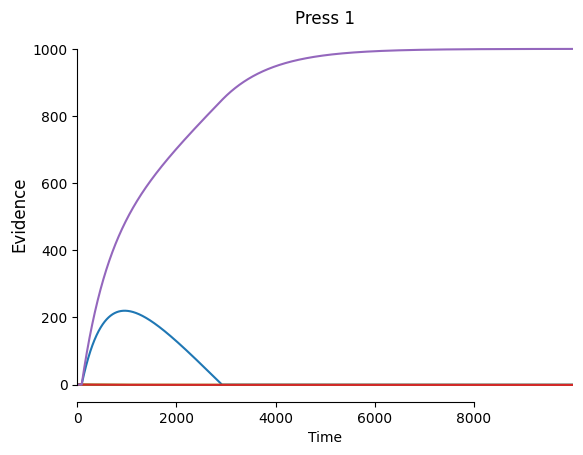

In [21]:
visual_drifts = calc_visual_drifts(rand_seq, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)


model = DriftDiffusionModel_Optimzied_damping_lateral(rand_seq, specific_seq, visual_drifts, memory_drifts, 
                                      diffusion = 0, threshold = np.inf, visual_delay=visual_delay, motor_delay=motor_delay, 
                                      planning_capacity=4, planning_param=2, seq_length=seq_length, alpha = alpha, beta= 0.001)
model.plot_simulations()
sns.despine(trim=True)


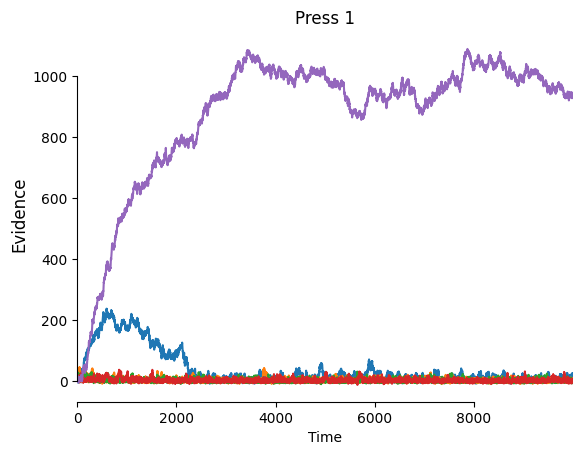

In [30]:
visual_drifts = calc_visual_drifts(rand_seq, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)


model = DriftDiffusionModel_Optimzied_damping_lateral(rand_seq, specific_seq, visual_drifts, memory_drifts, 
                                      diffusion, threshold = np.inf, visual_delay=visual_delay, motor_delay=motor_delay, 
                                      planning_capacity=4, planning_param=2, seq_length=seq_length, alpha = alpha, beta= beta)
model.plot_simulations()
sns.despine(trim=True)


In [23]:
n_sims = 1000
RTs = np.array([])
visual_drifts = calc_visual_drifts(rand_seq, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)
model = DriftDiffusionModel_Optimzied_damping_lateral(rand_seq, specific_seq, visual_drifts, memory_drifts, 
                                      diffusion, threshold = threshold, visual_delay=visual_delay, motor_delay = motor_delay,  
                                      planning_capacity=4, planning_param=2, seq_length=seq_length, alpha = alpha, beta = beta)

for sim in range(n_sims):
    ipis, evidence = model.simulate()
    RTs = np.append(ipis[0], RTs)

print(RTs.mean(), RTs.std())

/var/folders/wg/16zn32014z5grhdv06dk49f00000gn/T/ipykernel_92702/3550509832.py:41: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (Array(float64, 2, 'C', False, aligned=True), Array(float64, 2, 'A', False, aligned=True))
  evidence[:, current_press_planned: ] = A @ evidence[:, current_press_planned: ]


558.094 102.92812620464827


In [24]:
n_sims = 1000
RTs = np.array([])
visual_drifts = calc_visual_drifts(rand_seq, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)
model = DriftDiffusionModel_Optimzied_damping_lateral(rand_seq, specific_seq, visual_drifts, memory_drifts, 
                                      diffusion, threshold, visual_delay=visual_delay, motor_delay = motor_delay,
                                      planning_capacity=4, planning_param=2, seq_length=seq_length, alpha = alpha, beta = beta)

for sim in range(n_sims):
    ipis, evidence = model.simulate()
    RTs = np.append(RTs, check_evidence_to_seq(evidence, rand_seq))

print(RTs.mean(), RTs.std())

0.945 0.22798026230356


In [25]:
n_sims = 1000
RTs = np.array([])
visual_drifts = calc_visual_drifts(rand_seq, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)
model = DriftDiffusionModel_Optimzied_damping_lateral(rand_seq, specific_seq, visual_drifts, memory_drifts, 
                                      diffusion, threshold = np.inf, visual_delay=visual_delay, motor_delay = motor_delay,
                                      planning_capacity=4, planning_param=2, seq_length=seq_length, alpha = alpha, beta = beta)

for sim in range(n_sims):
    ipis, evidence = model.simulate()
    RTs = np.append(RTs, check_evidence_to_seq(evidence, rand_seq))

print(RTs.mean(), RTs.std())

1.0 0.0


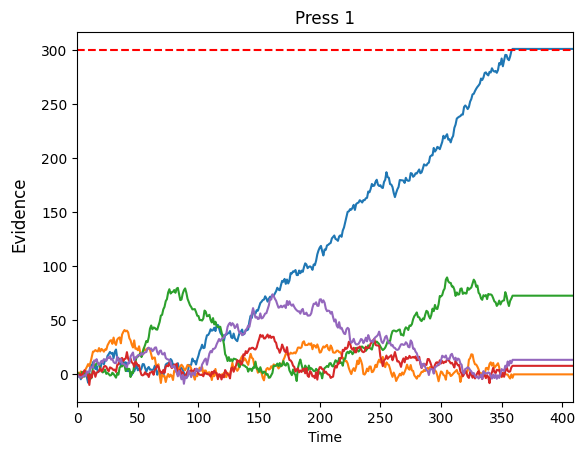

In [26]:
visual_drifts = calc_visual_drifts(specific_seq, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)

model = DriftDiffusionModel_Optimzied_damping_lateral(specific_seq, specific_seq, visual_drifts, memory_drifts, 
                                      diffusion, threshold, visual_delay=visual_delay, motor_delay = motor_delay, 
                                      planning_capacity=4, planning_param=2, seq_length=seq_length, alpha = alpha, beta = beta)
model.plot_simulations()

In [27]:
n_sims = 1000
RTs = np.array([])
visual_drifts = calc_visual_drifts(specific_seq, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)
model = DriftDiffusionModel_Optimzied_damping_lateral(rand_seq, specific_seq, visual_drifts, memory_drifts, 
                                      diffusion, threshold, visual_delay=visual_delay, motor_delay = motor_delay, 
                                      planning_capacity=4, planning_param=2, seq_length=seq_length, alpha = alpha, beta = beta)

for sim in range(n_sims):
    ipis, evidence = model.simulate()
    RTs = np.append(ipis[0], RTs)

print(RTs.mean(), RTs.std())

331.358 29.12472894294469


In [161]:
n_sims = 1000
RTs = np.array([])
visual_drifts = calc_visual_drifts(specific_seq, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)
model = DriftDiffusionModel_Optimzied_damping_lateral(rand_seq, specific_seq, visual_drifts, memory_drifts, 
                                      diffusion, threshold, visual_delay=visual_delay, motor_delay = motor_delay,
                                      planning_capacity=4, planning_param=2, seq_length=seq_length, alpha = alpha, beta = beta)

for sim in range(n_sims):
    ipis, evidence = model.simulate()
    RTs = np.append(RTs, check_evidence_to_seq(evidence, specific_seq))

print(RTs.mean(), RTs.std())

1.0 0.0


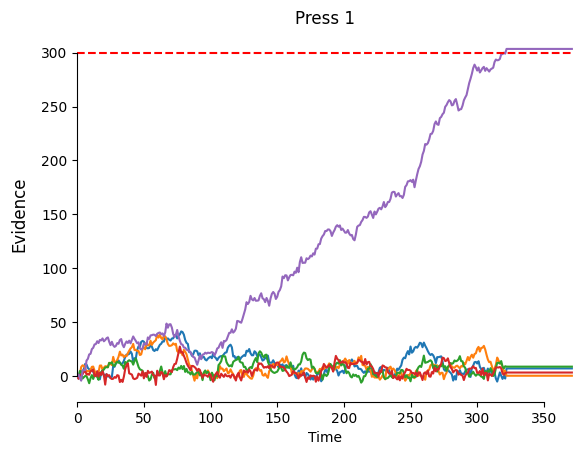

In [162]:
visual_drifts = calc_visual_drifts(rand_seq, seq_length)
memory_drifts = np.zeros((5, seq_length))

model = DriftDiffusionModel_Optimzied_damping_lateral(rand_seq, rand_seq, visual_drifts, memory_drifts, 
                                      diffusion, threshold = threshold, visual_delay=visual_delay, motor_delay = motor_delay,
                                      planning_capacity=4, planning_param=2, seq_length=seq_length, alpha = alpha, beta = beta)
model.plot_simulations()
sns.despine(trim = True)

In [27]:
n_sims = 1000
RTs = np.array([])
visual_drifts = calc_visual_drifts(rand_seq, seq_length)
memory_drifts = np.zeros((5, seq_length))
model = DriftDiffusionModel_Optimzied_damping_lateral(rand_seq, specific_seq, visual_drifts, memory_drifts, 
                                      diffusion, threshold, visual_delay=visual_delay, motor_delay = motor_delay,
                                      planning_capacity=4, planning_param=2, seq_length=seq_length, alpha = alpha, beta = beta)

for sim in range(n_sims):
    ipis, evidence = model.simulate()
    RTs = np.append(ipis[0], RTs)

print(RTs.mean(), RTs.std())

510.429 80.4740887428991


In [128]:
alpha

0.999

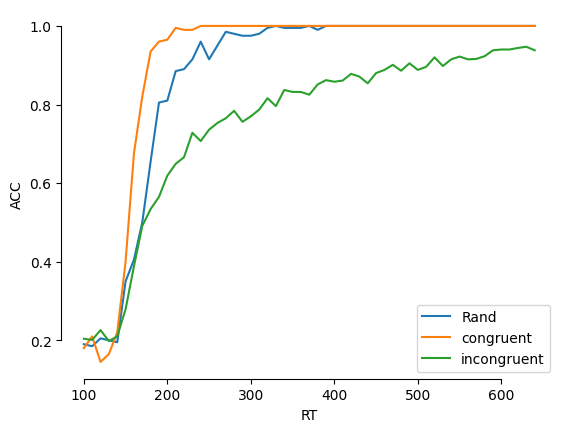

In [37]:
accs = []
for max_time in np.arange(50, 600, step = 10):    
    n_sims = 200
    RTs = np.array([])
    visual_drifts = calc_visual_drifts(rand_seq, seq_length)
    memory_drifts = np.zeros((5, seq_length))
    model = DriftDiffusionModel_Optimzied_damping_lateral(rand_seq, specific_seq, visual_drifts, memory_drifts, 
                                        diffusion, threshold = np.inf, visual_delay=visual_delay, motor_delay = motor_delay,
                                        planning_capacity=4, planning_param=2, seq_length=seq_length, alpha = alpha, beta = beta, max_time=max_time)

    for sim in range(n_sims):
        ipis, evidence = model.simulate()
        RTs = np.append(RTs, check_evidence_to_seq(evidence, rand_seq))
    accs.append(RTs.mean())

plt.plot(np.arange(50 + motor_delay,600 + motor_delay, step = 10), accs, label = 'Rand')

accs = []
for max_time in np.arange(50, 600, step = 10):    
    n_sims = 200
    RTs = np.array([])
    visual_drifts = calc_visual_drifts(specific_seq, seq_length)
    memory_drifts = calc_memory_drifts(specific_seq, seq_length)
    model = DriftDiffusionModel_Optimzied_damping_lateral(specific_seq, specific_seq, visual_drifts, memory_drifts, 
                                        diffusion, threshold = np.inf, visual_delay=visual_delay, motor_delay = motor_delay,
                                        planning_capacity=4, planning_param=2, seq_length=seq_length, alpha = alpha, beta = beta, max_time=max_time)

    for sim in range(n_sims):
        ipis, evidence = model.simulate()
        RTs = np.append(RTs, check_evidence_to_seq(evidence, specific_seq))
    accs.append(RTs.mean())

plt.plot(np.arange(50 + motor_delay,600 + motor_delay, step = 10), accs, label = 'congruent')


accs = []
for max_time in np.arange(50, 600, step = 10):    
    n_sims = 1000
    RTs = np.array([])
    visual_drifts = calc_visual_drifts(rand_seq, seq_length)
    memory_drifts = calc_memory_drifts(specific_seq, seq_length)
    model = DriftDiffusionModel_Optimzied_damping_lateral(rand_seq, specific_seq, visual_drifts, memory_drifts, 
                                        diffusion, threshold = np.inf, visual_delay=visual_delay, motor_delay = motor_delay,
                                        planning_capacity=4, planning_param=2, seq_length=seq_length, alpha = alpha, beta = beta, max_time=max_time)

    for sim in range(n_sims):
        ipis, evidence = model.simulate()
        RTs = np.append(RTs, check_evidence_to_seq(evidence, rand_seq))
    accs.append(RTs.mean())

plt.plot(np.arange(50 + motor_delay,600 + motor_delay, step = 10), accs, label = 'incongruent')


plt.xlabel('RT')
plt.ylabel('ACC')
plt.legend()
sns.despine(trim = True)
plt.show()

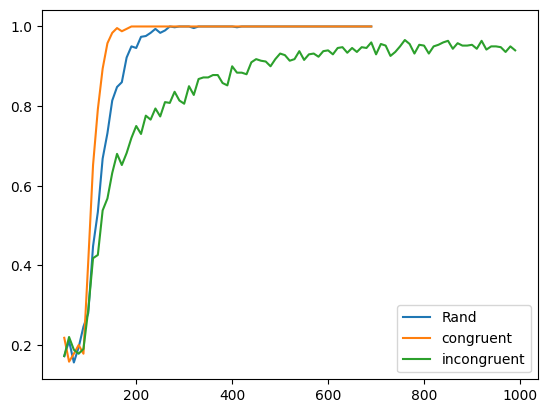

In [144]:
accs = []
for max_time in np.arange(50, 700, step = 10):    
    n_sims = 500
    RTs = np.array([])
    visual_drifts = calc_visual_drifts(rand_seq, seq_length)
    memory_drifts = np.zeros((5, seq_length))
    model = DriftDiffusionModel_Optimzied_damping_lateral(rand_seq, specific_seq, visual_drifts, memory_drifts, 
                                        diffusion, threshold, visual_delay=visual_delay, motor_delay=motor_delay, 
                                        planning_capacity=4, planning_param=2, seq_length=seq_length, alpha = alpha, beta= beta, max_time=max_time)

    for sim in range(n_sims):
        ipis, evidence = model.simulate()
        RTs = np.append(RTs, check_evidence_to_seq(evidence, rand_seq))
    accs.append(RTs.mean())

plt.plot(np.arange(50,700, step = 10), accs, label = 'Rand')

accs = []
for max_time in np.arange(50, 700, step = 10):    
    n_sims = 500
    RTs = np.array([])
    visual_drifts = calc_visual_drifts(specific_seq, seq_length)
    memory_drifts = calc_memory_drifts(specific_seq, seq_length)
    model = DriftDiffusionModel_Optimzied_damping_lateral(specific_seq, specific_seq, visual_drifts, memory_drifts, 
                                        diffusion, threshold, visual_delay=visual_delay, motor_delay=motor_delay, 
                                        planning_capacity=4, planning_param=2, seq_length=seq_length, alpha = alpha, beta = beta,  max_time=max_time)

    for sim in range(n_sims):
        ipis, evidence = model.simulate()
        RTs = np.append(RTs, check_evidence_to_seq(evidence, specific_seq))
    accs.append(RTs.mean())

plt.plot(np.arange(50,700, step = 10), accs, label = 'congruent')


accs = []
for max_time in np.arange(50, 1000, step = 10):    
    n_sims = 500
    RTs = np.array([])
    visual_drifts = calc_visual_drifts(rand_seq, seq_length)
    memory_drifts = calc_memory_drifts(specific_seq, seq_length)
    model = DriftDiffusionModel_Optimzied_damping_lateral(rand_seq, specific_seq, visual_drifts, memory_drifts, 
                                        diffusion, threshold, visual_delay=visual_delay, motor_delay=motor_delay, 
                                        planning_capacity=4, planning_param=2, seq_length=seq_length, alpha = alpha, beta = beta, max_time=max_time)

    for sim in range(n_sims):
        ipis, evidence = model.simulate()
        RTs = np.append(RTs, check_evidence_to_seq(evidence, rand_seq))
    accs.append(RTs.mean())

plt.plot(np.arange(50,1000, step = 10), accs, label = 'incongruent')



plt.legend()
plt.show()

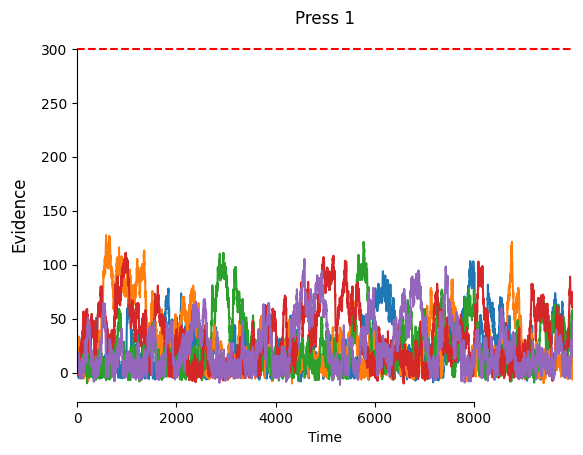

In [34]:
visual_drifts = np.zeros((5, seq_length))

memory_drifts = np.zeros((5, seq_length))

model = DriftDiffusionModel_Optimzied_damping_lateral(rand_seq, rand_seq, visual_drifts, memory_drifts, 
                                      diffusion, threshold, visual_delay=visual_delay, motor_delay = motor_delay,
                                      planning_capacity=4, planning_param=2, seq_length=seq_length, alpha = alpha, beta=beta)
model.plot_simulations()
sns.despine(trim=True)


In [77]:
n_sims = 1000
RTs = np.array([])
visual_drifts = np.zeros((5, seq_length))

memory_drifts = np.zeros((5, seq_length))
model = DriftDiffusionModel_Optimzied_damping_lateral(rand_seq, specific_seq, visual_drifts, memory_drifts, 
                                      diffusion, threshold = np.inf, visual_delay=visual_delay, motor_delay = motor_delay,
                                      planning_capacity=4, planning_param=2, seq_length=seq_length, alpha = alpha, beta = beta)

for sim in range(n_sims):
    ipis, evidence = model.simulate()
    RTs = np.append(RTs, ~(evidence >= threshold).any())

print(RTs.mean(), RTs.std())

1.0 0.0
